In [68]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

# Def: Read STL 10 images
def read_STL10_data():
    # read all of the data (STL 10) https://github.com/mttk/STL10
    def read_all_images(path_to_data):
        """
        :param path_to_data: the file containing the binary images from the STL-10 dataset
        :return: an array containing all the images
        """

        with open(path_to_data, 'rb') as f:
            # read whole file in uint8 chunks
            everything = np.fromfile(f, dtype=np.uint8)

            # We force the data into 3x96x96 chunks, since the
            # images are stored in "column-major order", meaning
            # that "the first 96*96 values are the red channel,
            # the next 96*96 are green, and the last are blue."
            # The -1 is since the size of the pictures depends
            # on the input file, and this way numpy determines
            # the size on its own.

            images = np.reshape(everything, (-1, 3, 96, 96))

            # Now transpose the images into a standard image format
            # readable by, for example, matplotlib.imshow
            # You might want to comment this line or reverse the shuffle
            # if you will use a learning algorithm like CNN, since they like
            # their channels separated.
            images = np.transpose(images, (0, 3, 2, 1))
            return images
    def read_labels(path_to_labels):
        """
        :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
        :return: an array containing the labels
        """
        with open(path_to_labels, 'rb') as f:
            labels = np.fromfile(f, dtype=np.uint8)
            return labels
    def show_images(data,row=1,col=1):
        fig=plt.figure(figsize=(10,10))
        columns = col; rows = row
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(data[i-1])
        plt.show()

    train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
    train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
    test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
    test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

    label_encoder= OneHotEncoder(sparse=False,categories='auto')
    train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
    test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

    print(train_images.shape,train_images.max(),train_images.min())
    print(train_labels.shape,train_labels.max(),train_labels.min())
    print(test_images.shape,test_images.max(),test_images.min())
    print(test_labels.shape,test_labels.max(),test_labels.min())
    return train_images,train_labels,test_images,test_labels

# Def: Read CIFAR 10 images
def read_CIFAR10_data():
    # ====== miscellaneous =====
    # code from: https://github.com/tensorflow/tensorflow/issues/8246
    def tf_repeat(tensor, repeats):
        """
        Args:

        input: A Tensor. 1-D or higher.
        repeats: A list. Number of repeat for each dimension, length must be the same as the number of dimensions in input

        Returns:

        A Tensor. Has the same type as input. Has the shape of tensor.shape * repeats
        """
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
        return repeated_tesnor
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    # ====== miscellaneous =====

    # data
    PathDicom = "../../../Dataset/cifar-10-batches-py/"
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if not ".html" in filename.lower() and not  ".meta" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))

    # Read the data traind and Test
    batch0 = unpickle(lstFilesDCM[0])
    batch1 = unpickle(lstFilesDCM[1])
    batch2 = unpickle(lstFilesDCM[2])
    batch3 = unpickle(lstFilesDCM[3])
    batch4 = unpickle(lstFilesDCM[4])

    onehot_encoder = OneHotEncoder(sparse=True)
    train_batch = np.vstack((batch0[b'data'],batch1[b'data'],batch2[b'data'],batch3[b'data'],batch4[b'data']))
    train_label = np.expand_dims(np.hstack((batch0[b'labels'],batch1[b'labels'],batch2[b'labels'],batch3[b'labels'],batch4[b'labels'])).T,axis=1).astype(np.float64)
    train_label = onehot_encoder.fit_transform(train_label).toarray().astype(np.float64)

    test_batch = unpickle(lstFilesDCM[5])[b'data']
    test_label = np.expand_dims(np.array(unpickle(lstFilesDCM[5])[b'labels']),axis=0).T.astype(np.float64)
    test_label = onehot_encoder.fit_transform(test_label).toarray().astype(np.float64)

    # reshape data
    train_batch = np.reshape(train_batch,(len(train_batch),3,32,32)); test_batch = np.reshape(test_batch,(len(test_batch),3,32,32))
    # rotate data
    train_batch = np.rot90(np.rot90(train_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64); test_batch = np.rot90(np.rot90(test_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64)
    # normalize
    train_batch= train_batch/255.0; test_batch = test_batch/255.0

    # print out the data shape and the max and min value
    print(train_batch.shape,train_batch.max(),train_batch.min())
    print(train_label.shape,train_label.max(),train_label.min())
    print(test_batch.shape,test_batch.max(),test_batch.min())
    print(test_label.shape,test_label.max(),test_label.min())
    return train_batch,train_label,test_batch,test_label

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


(50000, 32, 32, 3) 1.0 0.0
(50000, 10) 1.0 0.0
(10000, 32, 32, 3) 1.0 0.0
(10000, 10) 1.0 0.0


<function matplotlib.pyplot.show(*args, **kw)>

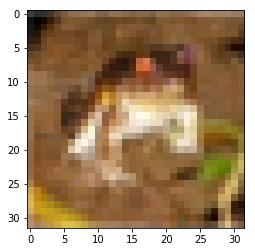

In [69]:
# read the data
train_images,train_labels,test_images,test_labels = read_CIFAR10_data()
plt.imshow(train_images[0])
plt.show()

In [55]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn as nn

import torch
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from pathlib import Path
import statistics as stats
import argparse

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(3, 64, kernel_size=4, stride=1)
        self.c1 = nn.Conv2d(64, 128, kernel_size=4, stride=1)
        self.c2 = nn.Conv2d(128, 256, kernel_size=4, stride=1)
        self.c3 = nn.Conv2d(256, 512, kernel_size=4, stride=1)
        self.l1 = nn.Linear(512*20*20, 64)

        self.b1 = nn.BatchNorm2d(128)
        self.b2 = nn.BatchNorm2d(256)
        self.b3 = nn.BatchNorm2d(512)

    def forward(self, x):
        h = F.relu(self.c0(x))                      # (64, 64, 29, 29)
        features = F.relu(self.b1(self.c1(h)))      # (64, 128, 26, 26)
        h = F.relu(self.b2(self.c2(features)))      # (64, 256, 23, 23)
        h = F.relu(self.b3(self.c3(h)))             # (64, 512, 20, 20)
        encoded = self.l1(h.view(x.shape[0], -1))   # (batch,64)
        return encoded, features

class GlobalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(128, 64, kernel_size=3) # (64, 64, 24, 24)
        self.c1 = nn.Conv2d(64, 32, kernel_size=3)  # (64, 32, 22, 22)
        self.l0 = nn.Linear(32 * 22 * 22 + 64, 512) # (64, 512)
        self.l1 = nn.Linear(512, 512)               # (512, 512)
        self.l2 = nn.Linear(512, 1)                 # (512, 1)

    def forward(self, y, M):
        h = F.relu(self.c0(M))
        h = self.c1(h)
        h = h.view(y.shape[0], -1)
        h = torch.cat((y, h), dim=1)
        h = F.relu(self.l0(h))
        h = F.relu(self.l1(h))
        return self.l2(h)
    
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(192, 512, kernel_size=1)
        self.c1 = nn.Conv2d(512, 512, kernel_size=1)
        self.c2 = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        return self.c2(h)
    
class PriorDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Linear(64, 1000)
        self.l1 = nn.Linear(1000, 200)
        self.l2 = nn.Linear(200, 1)

    def forward(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return torch.sigmoid(self.l2(h))

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(64, 15)
        self.bn1 = nn.BatchNorm1d(15)
        self.l2 = nn.Linear(15, 10)
        self.bn2 = nn.BatchNorm1d(10)
        self.l3 = nn.Linear(10, 10)
        self.bn3 = nn.BatchNorm1d(10)

    def forward(self, x):
        encoded, _ = x[0], x[1]
        clazz = F.relu(self.bn1(self.l1(encoded)))
        clazz = F.relu(self.bn2(self.l2(clazz)))
        clazz = F.softmax(self.bn3(self.l3(clazz)), dim=1)
        return clazz
class DeepInfoAsLatent(nn.Module):
    def __init__(self, run, epoch):
        super().__init__()
        model_path = Path(r'c:/data/deepinfomax/models') / Path(str(run)) / Path('encoder' + str(epoch) + '.wgt')
        self.encoder = Encoder()
        self.encoder.load_state_dict(torch.load(str(model_path)))
        self.classifier = Classifier()

    def forward(self, x):
        z, features = self.encoder(x)
        z = z.detach()
        return self.classifier((z, features))
    
class DeepInfoMaxLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=1.0, gamma=0.1):
        super().__init__()
        self.global_d = GlobalDiscriminator()
        self.local_d = LocalDiscriminator()
        self.prior_d = PriorDiscriminator()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, y, M, M_prime):

        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf

        y_exp = y.unsqueeze(-1).unsqueeze(-1)
        y_exp = y_exp.expand(-1, -1, 26, 26)
        y_M = torch.cat((M, y_exp), dim=1)
        y_M_prime = torch.cat((M_prime, y_exp), dim=1)
        Ej = -F.softplus(-self.local_d(y_M)).mean()
        Em = F.softplus(self.local_d(y_M_prime)).mean()
        LOCAL = (Em - Ej) * self.beta
        
        # global         
        Ej = -F.softplus(-self.global_d(y, M)).mean()
        Em = F.softplus(self.global_d(y, M_prime)).mean()
        GLOBAL = (Em - Ej) * self.alpha

        prior = torch.rand_like(y)
        term_a = torch.log(self.prior_d(prior)).mean()
        term_b = torch.log(1.0 - self.prior_d(y)).mean()
        PRIOR = - (term_a + term_b) * self.gamma

        return LOCAL + GLOBAL + PRIOR


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

# image size 3, 32, 32 batch size must be an even numbershuffle must be True
cifar_10_train_dt = CIFAR10(r'c:\data\tv',  download=True, transform=ToTensor())
cifar_10_train_l  = DataLoader(cifar_10_train_dt, batch_size=batch_size, shuffle=True, drop_last=True,pin_memory=torch.cuda.is_available())

encoder    = Encoder().to(device)
loss_fn    = DeepInfoMaxLoss().to(device)
optim      = Adam(encoder.parameters(), lr=1e-4)
loss_optim = Adam(loss_fn.parameters(), lr=1e-4)

for epoch in range(100):
    batch = tqdm(cifar_10_train_l, total=len(cifar_10_train_dt) // batch_size)
    train_loss = []
    
    for x, target in batch:
        x = x.to(device)

        optim.zero_grad(); loss_optim.zero_grad()
        y, M = encoder(x)
        # y - > (64, 128, 26, 26)
        # M - > (batch,64)
        
        # rotate images to create pairs for comparison (ROTATING)
        M_prime = torch.cat((M[1:], M[0].unsqueeze(0)), dim=0)
        loss = loss_fn(y, M, M_prime) # ()
        sys.exit()
        
        train_loss.append(loss.item())
        batch.set_description(str(epoch) + ' Loss: ' + str(stats.mean(train_loss[-20:])))
        loss.backward()
        optim.step(); loss_optim.step()
        sys.exit()

Files already downloaded and verified




































  0%|                                                                                               | 0/781 [00:00<?, ?it/s]

()


SystemExit: 

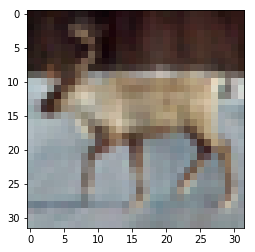

(64, 32, 32, 3)
(64,)


SystemExit: 

In [28]:
# batch = tqdm(cifar_10_train_l, total=len(cifar_10_train_dt) // batch_size)
for x, target in batch:
    temp = np.swapaxes(np.swapaxes(x.numpy(),1,3),2,1)
    plt.imshow(temp[0])
    plt.show()
    print(temp.shape)
    print(target.numpy().shape)
    sys.exit()